# Authorship Attribution Petition

Sam McDowell \
12/5/2025

## Pretrained Model Results

### Imports

In [1]:
%pip install transformers datasets umap-learn accelerate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import random

import torch
import transformers

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

# optional: set random seeds for reproducibility
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

### BERT Authorship Attribution

Format Data

In [3]:
df = pd.read_csv("./data/preprocessed.csv")
train, test = train_test_split(df, test_size=0.2, stratify=df['id'], random_state=1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [4]:
train = train[["prp_text", "id"]]
test = test[["prp_text", "id"]]
train.shape, test.shape

((480, 2), (120, 2))

In [5]:
%%capture

# rename column 'prp_text' to 'text' for tokenizer compatibility
train = train.rename(columns={'prp_text': 'text'})
test = test.rename(columns={'prp_text': 'text'})

# build a DatasetDict from pandas DataFrames (reset index to avoid pandas index column)
dataset = DatasetDict({
    'train': Dataset.from_pandas(train.reset_index(drop=True)),
    'test': Dataset.from_pandas(test.reset_index(drop=True)),
})

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)

# tokenize both splits in a batched way
dataset = dataset.map(tokenize, batched=True)

# map string ids to integer labels using combined label set
all_labels = sorted(set(dataset['train']['id']) | set(dataset['test']['id']))
label2id = {lab: i for i, lab in enumerate(all_labels)}

def add_labels(batch):
    return {'labels': [label2id[x] for x in batch['id']]}

dataset = dataset.map(add_labels, batched=True)

# remove original text/id columns and any pandas index column
dataset = dataset.remove_columns(['text', 'id'])

# prepare torch tensors for Trainer
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [6]:
# create the bert model with a head
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=train["id"].nunique()
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    output_dir="./bert-authorship",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    metric_for_best_model="f1_macro",
    load_best_model_at_end=True,
    seed=1,
    logging_strategy="epoch",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
        ],  # stop after 3 evals with no improvement
)

train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.562100,2.227897,0.358333,0.331604
2,1.883600,1.575201,0.700000,0.677525
3,1.248300,1.112861,0.750000,0.741874
4,0.737200,0.840292,0.775000,0.772359
5,0.414100,0.618550,0.866667,0.866388
6,0.194400,0.612385,0.800000,0.793023
7,0.084600,0.500553,0.825000,0.822344
8,0.041200,0.521770,0.841667,0.837366


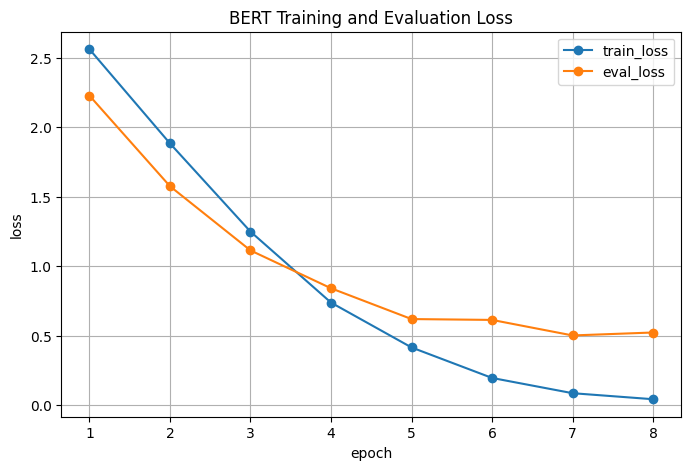

In [8]:
logs = trainer.state.log_history
if not logs:
    print("No log history available")
else:
    df = pd.DataFrame(logs)

    # Extract per-epoch training + eval loss (keep last entry per epoch)
    train_loss = (
        df.dropna(subset=['loss'])
          .groupby('epoch')['loss']
          .last()
    )

    eval_loss = (
        df.dropna(subset=['eval_loss'])
          .groupby('epoch')['eval_loss']
          .last())

    # Plot
    plt.figure(figsize=(8,5))
    if len(train_loss):
        plt.plot(train_loss.index, train_loss.values, marker='o', label='train_loss')
    if len(eval_loss):
        plt.plot(eval_loss.index, eval_loss.values, marker='o', label='eval_loss')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('BERT Training and Evaluation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

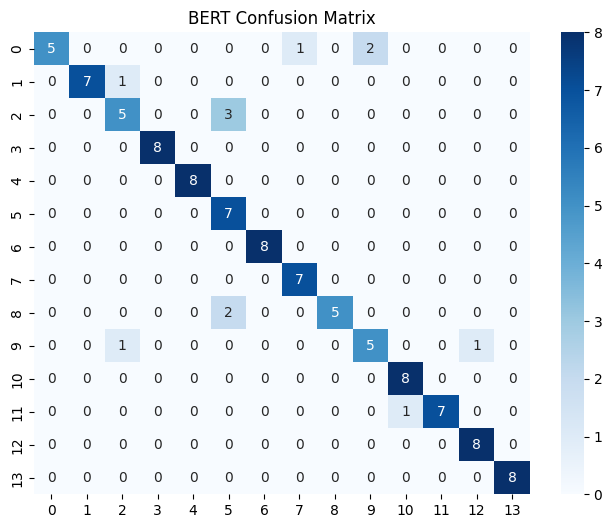

In [23]:
pred_out = trainer.predict(dataset["test"])   # returns PredictionOutput(predictions, label_ids, metrics)
y_pred = np.argmax(pred_out.predictions, axis=1)
y_true = pred_out.label_ids

# Example: y_true and y_pred are your labels
report = confusion_matrix(y_true, y_pred)

# Convert to DataFrame
df_report = pd.DataFrame(report)

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
plt.title("BERT Confusion Matrix")
plt.savefig("output/BERT_classification.png")
plt.show()

In [10]:
print("Test loss (from predict):", pred_out.metrics.get("test_loss", None))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))
print("Classification report:")
print(classification_report(y_true, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Test loss (from predict): 0.6185502409934998
Accuracy: 0.8666666666666667
F1 (macro): 0.8663876319758673
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.88      0.93         8
           2       0.71      0.62      0.67         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.58      0.88      0.70         8
           6       1.00      1.00      1.00         8
           7       0.88      0.88      0.88         8
           8       1.00      0.62      0.77         8
           9       0.71      0.62      0.67         8
          10       0.89      1.00      0.94         8
          11       1.00      0.88      0.93         8
          12       0.89      1.00      0.94         8
          13       1.00      1.00      1.00         8
          14       0.67      1.00      0.80         8

    ac

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --------------------------
# TEST CUSTOM TEXT
# --------------------------
print("Custom Text Test")
text = "Some new writing sample"
tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# move token tensors to the same device as the model
tokens = {k: v.to(device) for k, v in tokens.items()}

with torch.no_grad():
    output = model(**tokens)

predicted_author = output.logits.argmax(dim=1).item()
print("Author:", predicted_author)

# --------------------------
# RANDOM TESTSET EXAMPLE
# --------------------------
print("\nRandom Test Item")
for _ in range(3):
    i = random.randint(0, len(dataset["test"]) - 1)

    # Raw input_ids from dataset
    input_ids = dataset["test"][i]["input_ids"]
    label = dataset["test"][i]["labels"]

    # Convert to tensor
    input_ids = input_ids.unsqueeze(0).to(device)
    attention_mask = (input_ids != 0).long().to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)

    pred = output.logits.argmax(dim=1).item()

    print(f"Sample {i} →\tPredicted: {pred} | Actual: {label}")

Custom Text Test
Author: 7

Random Test Item
Sample 17 →	Predicted: 4 | Actual: 4
Sample 72 →	Predicted: 11 | Actual: 11
Sample 108 →	Predicted: 12 | Actual: 12


### Cosine Similarity of Embeddings

In [12]:
model = SentenceTransformer("all-mpnet-base-v2")

df = pd.read_csv("./data/preprocessed.csv")
train, test = train_test_split(df, test_size=0.2, stratify=df['id'], random_state=1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [13]:
texts = train["prp_text"].tolist()
embeddings = model.encode(texts, batch_size=32, convert_to_tensor=True)


In [14]:
author_vectors = {}  # author -> embedding tensor

for author in train["id"].unique():
    idx = train[train["id"] == author].index
    vecs = embeddings[idx]                      # all embeddings for this author
    centroid = torch.mean(vecs, dim=0)          # average embedding
    author_vectors[author] = centroid


In [15]:
def predict_author(text, threshold=0.3):
    # Embed text
    vec = model.encode(text, convert_to_tensor=True)
    
    # Compute similarity to each author
    sims = {
        author: cosine_similarity(vec, centroid, dim=0).item()
        for author, centroid in author_vectors.items()
    }
    
    # Find best match
    best_author = max(sims, key=sims.get)
    best_score = sims[best_author]

    # Optional: open-set detection
    if best_score < threshold:
        return "UNKNOWN", best_score, sims
    
    return best_author, best_score, sims


In [16]:
author, score, sims = predict_author("This is a sample text")
print(author, score)

true, preds = [], []
for i, r in test.iterrows():
    true.append(str(r["id"]))
    p_auth, _, _ = predict_author(r["prp_text"])
    preds.append(str(p_auth))

print(true)
print(preds)


UNKNOWN 0.2108108401298523
['1476382', '2922061', '2922061', '1234212', '216413', '215223', '2922061', '216413', '2587254', '1234212', '1476382', '1234212', '2872565', '2587254', '2587254', '1604072', '215223', '1151815', '470861', '1151815', '216413', '2639424', '216413', '1151815', '1151815', '2822042', '215223', '2872565', '2186817', '2639424', '1234212', '215223', '215223', '215223', '2639424', '2872565', '2822042', '2186817', '554681', '2639424', '216413', '2186817', '1510754', '2822042', '1604072', '554681', '216413', '554681', '1151815', '1510754', '2872565', '2922061', '1234212', '2872565', '2922061', '216413', '1151815', '1476382', '2186817', '2922061', '2922061', '2639424', '216413', '470861', '470861', '1151815', '470861', '1604072', '2587254', '1604072', '1604072', '470861', '2639424', '1510754', '1510754', '2587254', '2639424', '1604072', '2587254', '470861', '1476382', '2822042', '215223', '554681', '1510754', '1510754', '2822042', '2822042', '470861', '2872565', '1234212

In [17]:
print("Accuracy:", accuracy_score(true, preds))
print("F1 (macro):", f1_score(true, preds, average="macro"))
print("Classification report:")
print(classification_report(true, preds, zero_division=0))
print("Confusion matrix:")
print(confusion_matrix(true, preds))

Accuracy: 0.7583333333333333
F1 (macro): 0.7137996646026832
Classification report:
              precision    recall  f1-score   support

     1151815       1.00      1.00      1.00         8
     1234212       1.00      0.50      0.67         8
     1476382       0.89      1.00      0.94         8
     1510754       0.71      0.62      0.67         8
     1604072       0.38      0.38      0.38         8
      215223       0.60      0.75      0.67         8
      216413       0.71      0.62      0.67         8
     2186817       0.38      0.38      0.38         8
     2587254       0.89      1.00      0.94         8
     2639424       0.78      0.88      0.82         8
     2822042       0.86      0.75      0.80         8
     2872565       1.00      0.88      0.93         8
     2922061       0.55      0.75      0.63         8
      470861       1.00      0.88      0.93         8
      554681       1.00      1.00      1.00         8
     UNKNOWN       0.00      0.00      0.00         

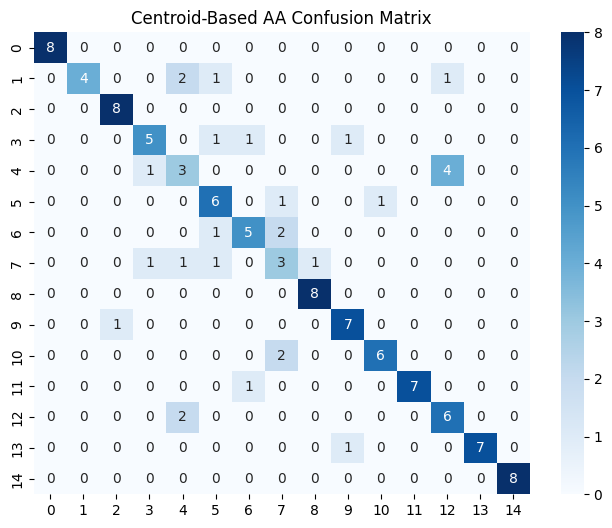

In [24]:
# Example: y_true and y_pred are your labels
report = confusion_matrix(true, preds)

# Convert to DataFrame
df_report = pd.DataFrame(report)

plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
plt.title("Centroid-Based AA Confusion Matrix")
plt.savefig("output/CosSim_classification.png")
plt.show()

c:\Users\sam_m\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


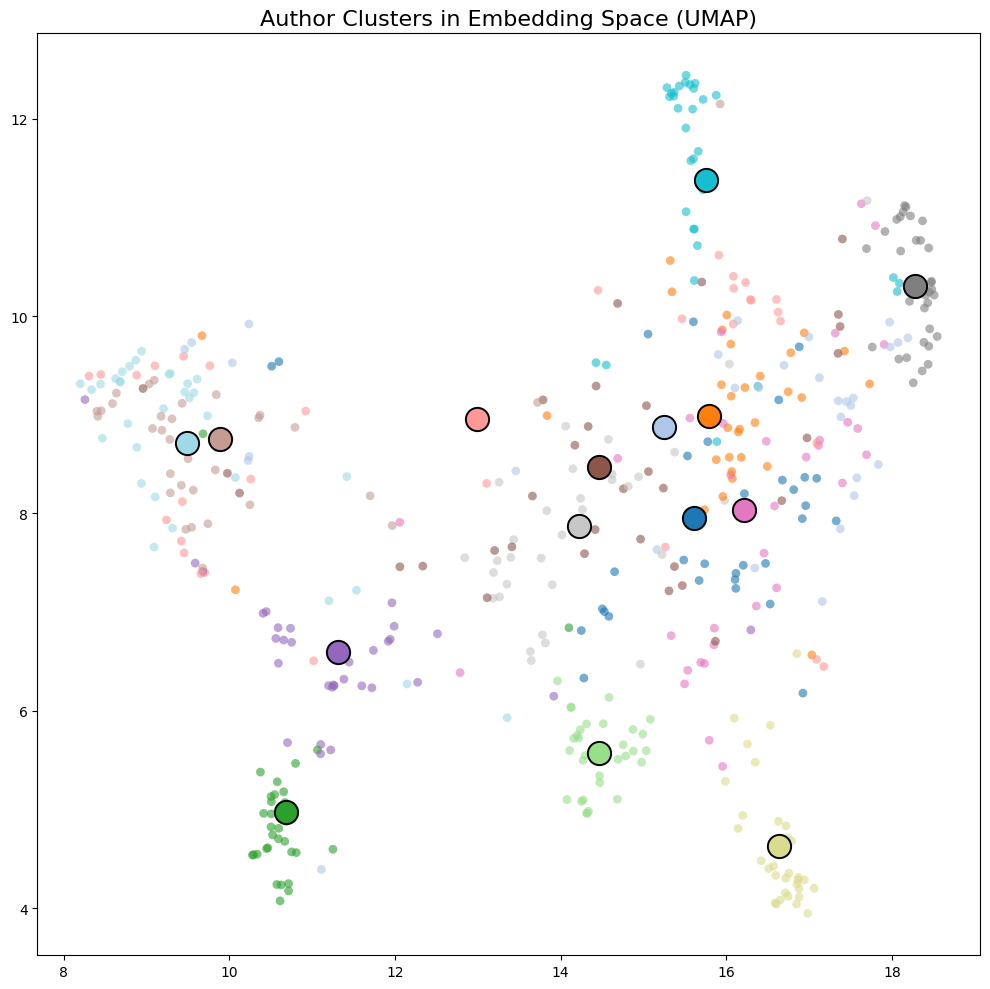

In [19]:
if hasattr(embeddings, 'cpu'): 
    emb_np = embeddings.cpu().numpy().astype('float32') 
else: emb_np = np.asarray(embeddings, dtype='float32') 

# --- BETTER UMAP PARAMETERS --- 
reducer = umap.UMAP(n_neighbors=30, # smoother global structure 
                    min_dist=0.0, # tighter clusters 
                    n_components=2, 
                    metric='cosine', 
                    random_state=42, 
                    spread=1.5, 
                    init='spectral', 
) 

embedding_2d = reducer.fit_transform(emb_np)

# Convert authors to labels 
authors = train["id"].astype("category") 
author_ids = authors.cat.codes 
categories = authors.cat.categories

# --- CENTROIDS --- 
centroids = [] 
for i, cat in enumerate(categories): 
    idx = np.where(author_ids == i)[0] 
    if len(idx) == 0: 
        centroids.append(np.array([np.nan, np.nan])) 
    else: 
        centroids.append(embedding_2d[idx].mean(axis=0)) 
centroids = np.vstack(centroids)

# Create a normalization so both scatter + centroids use same mapping
norm = colors.Normalize(vmin=author_ids.min(), vmax=author_ids.max())
cmap = plt.get_cmap("tab20")

plt.figure(figsize=(10, 10))

# --- SCATTER POINTS ---
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=author_ids,
    cmap=cmap,
    norm=norm,          # <--- IMPORTANT
    s=40,
    alpha=0.6,
    edgecolor="none",
)

# --- CENTROIDS ---
for i, cat in enumerate(categories):
    if np.isfinite(centroids[i]).all():
        plt.scatter(
            centroids[i, 0],
            centroids[i, 1],
            marker="o",
            s=280,
            color=cmap(norm(i)),   # <--- SAME COLOR AS SCATTER
            edgecolor="black",
            linewidth=1.4,
            zorder=10,
        )

plt.title("Author Clusters in Embedding Space (UMAP)", fontsize=16)
plt.tight_layout()
plt.show()
